In [1]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing import image
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras
import numpy as np
import csv
import pickle
import argparse
import sklearn.metrics, math
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
def extract_days():
    df = pd.read_csv('PMIs', sep = ":", names=['path', 'pmi'])
    day_per_donor = {}
    for index, row in df.iterrows():
        if row['path'].split('/')[-2] not in day_per_donor:
            day_per_donor[row['path'].split('/')[-2]] = \
            df[df['path'].str.contains(row['path'].split('/')[-2])]['pmi'].sort_values().iloc[-1]
    return day_per_donor

day_per_donor = extract_days()



In [4]:
base_model_img_size = 224

def small_net():
    num_classes = 500#285#train_labels.shape[1]
    # initialize the model
    model = Sequential()
    inputShape = (base_model_img_size, base_model_img_size, 3)
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(32, (5, 5), padding="same",
            input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    # second set of FC => RELU layers
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    #model.add(Dense(num_classes, activation='softmax'))
    #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipvalue = 0.5)
    #model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics=['acc'])
    model.add(Dense(1))
    optimizer = tensorflow.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

loaded_model = small_net()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
not_found = 0
X = []
Y = []
train_data_paths = 'june_cases_PMI_shuf_test'#'january_cases_classified_body_parts_PMIs_shuf_NoSP_test'
images = []
images_names = []
with open(train_data_paths, 'r') as file_:
    csv_reader = csv.reader(file_, delimiter = ":")
    for row in csv_reader:
        try:
            pmi = int(row[1].strip())
            img = image.load_img(row[0].strip(),
                    target_size = (base_model_img_size,
                     base_model_img_size, 3), grayscale = False)
            images.append(img)
            images_names.append(row[0].strip())
            img = image.img_to_array(img)
            img = img/255
            X.append(img)
            Y.append([pmi, day_per_donor[row[0].split('/')[-2]]])
        except:
            print("couldn't load", row)

X = np.array(X)
Y = np.array(Y)


In [10]:
#loaded_model.load_weights('Best_January_epoch_-024-_loss_3.448049-_val_loss_4.36503.h5')
#loaded_model.load_weights('foot_models/foot_epoch_-280-_loss_0.852961-_val_loss_5.98759.h5')
#loaded_model.load_weights('Best2_January_epoch_-008-_loss_1.598702-_val_loss_8.77076.h5')
#loaded_model.load_weights('FootJanuary_epoch_-086-_loss_2.137899-_val_loss_2.74739.h5')
#loaded_model.load_weights('January_foot_regression_epoch_-046-_loss_311.963615-_val_loss_1186.91399.h5')
#loaded_model.load_weights('models/January_regression_epoch_-003-_loss_1310.308454-_val_loss_1558.01613.h5')

loaded_model.load_weights('June_regression_epoch_-017-_loss_199.297130-_val_loss_683.70539.h5')


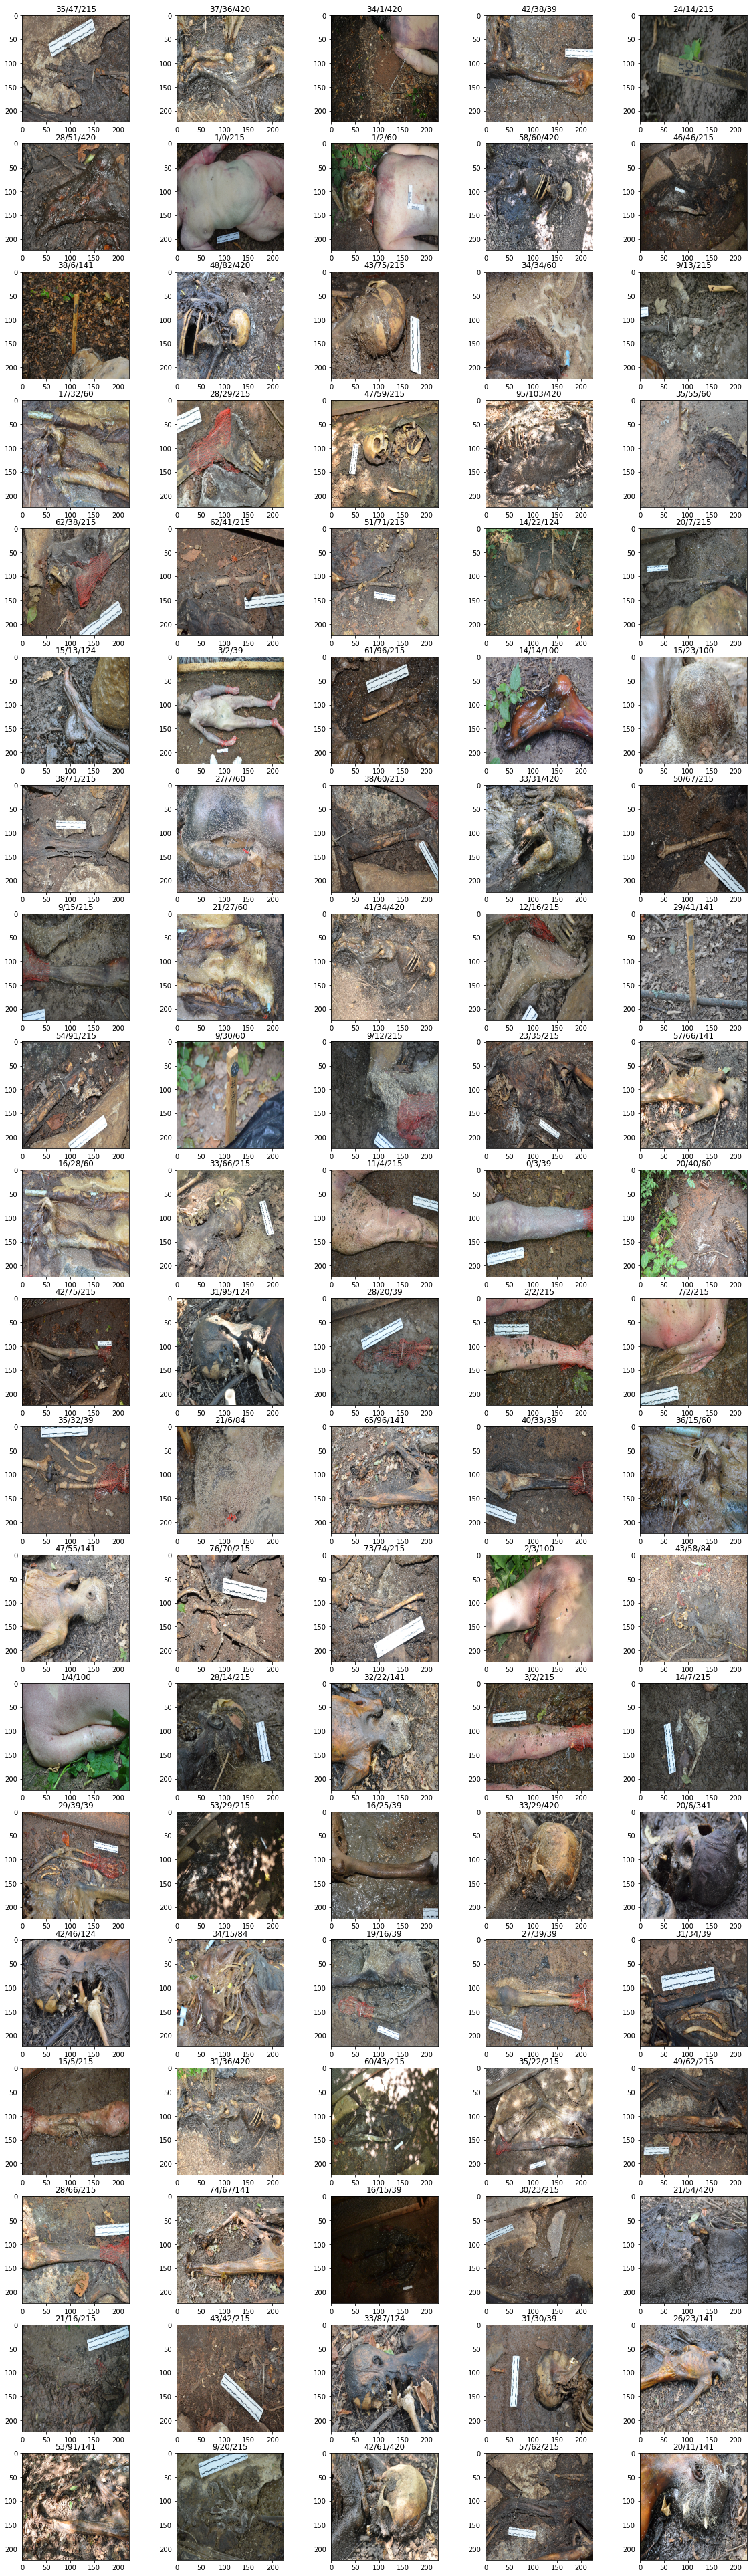

In [11]:
import numpy as np
import matplotlib.pyplot as plt

preds = loaded_model.predict(X)
pred = preds[:,0].astype(int) #preds.argmax(axis=-1) #if classifier
    
 
fig = plt.figure(figsize=(20, 70))

columns = 5
rows = 20
ax = []
for i in range(0, columns*rows):
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title(str(pred[i])+"/"+str(Y[i][0])+"/"+str(Y[i][1]))
    plt.imshow(images[i])
plt.show()


In [12]:
def sara_metric(y_true, y_pred):
    y_class = y_true[:,0]
    y_days = y_true[:,1]
    loss=(1/y_days)*(abs(y_class - y_pred))
    return loss

d = sara_metric(Y, pred)
#print("d: {}".format(d))
print("mean of prediction deviation: ", np.mean(d))

mean of prediction deviation:  0.11293761973917489


In [9]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

preds = loaded_model.predict(X)
pred = preds.argmax(axis=-1)

print(sklearn.metrics.mean_absolute_error(Y[:,0], pred))
print(sklearn.metrics.median_absolute_error(Y[:,0], pred))

65.89308492782813
52.0


In [11]:
images_names[87]

'/home/mousavi/da1/icputrd/arf/mean.js/public/sara_img/368/36800511.42.JPG'